# $D_S$ analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib

from hstar import c6
from inference import stat

## Computation of $D_S$

The discriminant is defined as

$$D_S = \log_{10} \left( \frac{|\mathcal{M}_{gg\to h^{\ast}\to ZZ}|^2}{|\mathcal{M}_{gg\to ZZ}|^2 + c\cdot |\mathcal{M}_{q\bar{q}\to ZZ}|^2} \right),$$

where $c = 0.1$ is an arbitrary and empirical factor. This variable will be computed for a generated dataset by constructing two samples out of the same set of events as the following:

1. Fully-physical $gg \to ZZ$ sample from which both its matrix element and the event weight can be morphed to $c_6$.
2. Unphysical $gg \to h^{\ast} \to ZZ$ sample from which only its matrix element is morphed to $c_6$.
3. Unphysical $q\bar{q} \to ZZ$ samples from which only its leading-order SM matrix element is taken, never morphed to $c_6$.

However, there are some ambiguities in this definition:

- 
- What does $\mathcal{M}_{q\bar{q} \to ZZ}$ exactly mean? One could presume it is the (sum over) all $q\bar{q}$ configurations.
  - MCFM yields unique non-zero values for $u\bar{u}, d\bar{d}, \bar{u}u, \bar{d}d$, where $u = (u, c)$ and $d = (d, s, b)$.

Along with discrepancies with respect to this as implemented in the Uli and Gabriel's paper:

- Only $u\bar{u}$ configuration is considered.
  - Presumably, Gabriel assumed $\mathcal{M}_{u\bar{u} \to ZZ} = \mathcal{M}_{d\bar{d} \to ZZ} = \mathcal{M}_{\bar{u}u \to ZZ} = \mathcal{M}_{\bar{d}d \to ZZ}$.
- There is an extra factor of $1/2$ on top of $c = 0.1$.
  - No clue why this is; if anything, he should have done $\times 2$ or something considering the above.

Proceeding with these caveats, the following full definition is used to try to reproduce the paper results:

$$D_S = \log_{10} \left( \frac{|\mathcal{M}_{gg\to h^{\ast}\to ZZ}|^2}{|\mathcal{M}_{gg\to ZZ}|^2 + 0.1 \cdot 1/2 \cdot |\mathcal{M}_{u\bar{u}\to ZZ}|^2} \right).$$

## Starting off with the "signal" $gg(\to h^{\ast})\to ZZ$ process

For now, we start by looking at only the $gg$-initiated channel. 
As mentioned already above, $\mathcal{M}_{u\bar{u}\to ZZ}$ is computed for the incoming & outgoing four-momenta configuration assuming the incoming partons were quarks instead.
With foresight, the samples are labeld as `sbi_` to indicate that it contains the signal+background+interference amplitudes.

In [2]:
# read dataset
filepath = '/raven/u/taepa/mcfm/MCFM-10.3/Bin/ggZZ2e2m_all/events.csv'
events = pd.read_csv(filepath)

lumi = 300.0

# full gg->ZZ sample
# note: normalizing the event weights because they are important!
sbi_ggzz = c6.Sample(k=1.83, xs=1.4783394, events=events) # cross-section x k-factor [fb]
sbi_ggzz.sm_msq_key = 'msq_gg_sm'
sbi_ggzz.c6_msq_map = {
    -5 : 'msq_gg_c6_6',
    -1 : 'msq_gg_c6_10',
    0 : 'msq_gg_c6_11',
    1 : 'msq_gg_c6_12',
    5 : 'msq_gg_c6_16'
  }
sbi_ggzz.normalize(lumi)

# signal-only gg->h*->ZZ sample
# note: negative cross-section, because it doesn't matter!
sbi_gghzz = c6.Sample(xs=-99, events=events)
sbi_gghzz.sm_msq_key = 'msq_h_sm'
sbi_gghzz.c6_msq_map = {
    -5 : 'msq_h_c6_6',
    -1 : 'msq_h_c6_10',
    0 : 'msq_h_c6_11',
    1 : 'msq_h_c6_12',
    5 : 'msq_h_c6_16'
  }

sbi_uubzz = c6.Sample(xs=-99, events=events)
sbi_uubzz.sm_msq_key = 'msq_uub'

# sbi_ddbzz = c6.Sample(xs=-99, events=events)
# sbi_ddbzz.sm_msq_key = 'msq_ddb'
# sbi_ubuzz = c6.Sample(xs=-99, events=events)
# sbi_ubuzz.sm_msq_key = 'msq_ubu'
# sbi_dbdzz = c6.Sample(xs=-99, events=events)
# sbi_dbdzz.sm_msq_key = 'msq_dbd'

In [3]:
# c6 values
c6_vals = np.array([10.0, 20.0, 30.0])

# SM
sbi_ds_sm = np.log10(sbi_gghzz.msq() / (sbi_ggzz.msq() + 0.1*0.5*sbi_uubzz.msq()))
sbi_nu_sm = sbi_ggzz.nu(per_event=True)

# ME
sbi_msq_gghzz_c6 = sbi_gghzz.msq(c6_vals)
sbi_msq_ggzz_c6 = sbi_ggzz.msq(c6_vals)
sbi_ds_c6 = np.log10(sbi_msq_gghzz_c6 / (sbi_msq_ggzz_c6 + 0.1*0.5*(sbi_uubzz.msq())[:, np.newaxis]))

# event weight
sbi_nu_c6 = sbi_ggzz.nu(c6_vals,per_event=True)

/tmp/ipykernel_124241/124206740.py:11: RuntimeWarning: invalid value encountered in log10
  sbi_ds_c6 = np.log10(sbi_msq_gghzz_c6 / (sbi_msq_ggzz_c6 + 0.1*0.5*(sbi_uubzz.msq())[:, np.newaxis]))


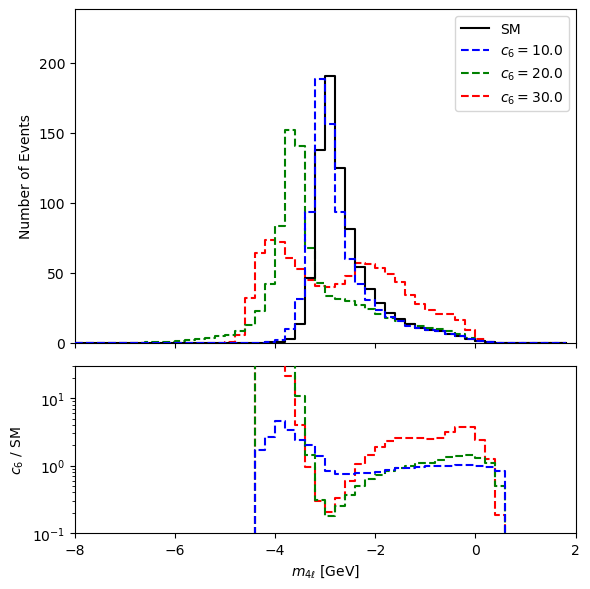

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True, height_ratios=(2,1))

ds_bins = np.arange(-8,2.2,0.2)
ds_sm_centers = 0.5 * (ds_bins[1:] + ds_bins[:-1])

h_ds_sm, _ = np.histogram(sbi_ds_sm, bins=ds_bins, weights=sbi_nu_sm)
ax1.step(ds_bins[:-1], h_ds_sm, where='post', color='black', label='SM', zorder=10)

colors= 'bgrcmy'
for i, c6_val in enumerate(c6_vals):
  if np.isclose(c6_val, 0.0):
    continue
  h_ds_c6, _ = np.histogram(sbi_ds_c6[:, i], bins=ds_bins, weights=sbi_nu_c6[:, i])
  ax1.step(ds_bins[:-1], h_ds_c6, '--', color=colors[i], where='post', label=f'$c_6 = {c6_val}$', zorder=10-i)
  ratio = np.divide(h_ds_c6, h_ds_sm, out=np.zeros_like(h_ds_sm), where=h_ds_sm!=0)
  ax2.step(ds_bins[:-1], ratio, '--', color=colors[i],  where='post', label=f'$c_6 = {c6_val}$', zorder=10-i)


ax1.set_xlim(-8,2)
ax1.set_ylabel('Number of Events')
ax1.set_ylim(0, 1.25*np.max(h_ds_sm))
# ax1.set_yscale('log')
ax1.legend()

ax2.set_ylim(0.0,2.0)
ax2.set_xlabel('$m_{4\\ell}$ [GeV]')
ax2.set_ylabel('$c_6$ / SM')
ax2.set_ylim(1e-1,30.0)
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

## Adding in background $q\bar{q} \to ZZ$

Note that the generated dataset above is purely from the $gg(\to h^{\ast})\to ZZ$ process. The matrix element corresponding to $q\bar{q}\to ZZ$ is computed for those events (again, ignoring the parton flavours), but this was purely for the computation of the event discriminant $D_S$.
Now, the corresponding contribution from the actual $q\bar{q}\to ZZ$ process must also be accounted for.
These are labeld `bkg_` as they are strictly $c_6$-independent.

In [5]:
# read dataset
bkg_filepath = '/raven/u/taepa/mcfm/MCFM-10.3/Bin/qqZZ2e2m/events.csv'
bkg_events = pd.read_csv(bkg_filepath)

# normalize the physical sample
bkg_qqbzz = c6.Sample(k=1.55, xs=13.988626, events=bkg_events)
bkg_qqbzz.normalize(lumi)

# this time, the gg(->h*)->zz samples are unphysical
bkg_ggzz = c6.Sample(xs=-99, events=bkg_events) # cross-section x k-factor [fb]
bkg_ggzz.sm_msq_key = 'msq_gg_sm'
bkg_ggzz.c6_msq_map = {
    -5 : 'msq_gg_c6_6',
    -1 : 'msq_gg_c6_10',
    0 : 'msq_gg_c6_11',
    1 : 'msq_gg_c6_12',
    5 : 'msq_gg_c6_16'
  }
bkg_gghzz = c6.Sample(xs=-99, events=bkg_events)
bkg_gghzz.sm_msq_key = 'msq_h_sm'
bkg_gghzz.c6_msq_map = {
    -5 : 'msq_h_c6_6',
    -1 : 'msq_h_c6_10',
    0 : 'msq_h_c6_11',
    1 : 'msq_h_c6_12',
    5 : 'msq_h_c6_16'
  }

# the uub sample is still unphysical (because it's the inclusive qqbar that was generated)
bkg_uubzz = c6.Sample(xs=-99, events=bkg_events)
bkg_uubzz.sm_msq_key = 'msq_uub'

In [9]:
bkg_ds_sm = np.log10(bkg_gghzz.msq() / (bkg_ggzz.msq() + 0.1*0.5*bkg_uubzz.msq()))
bkg_nu_sm = bkg_qqbzz.nu(per_event=True)
bkg_msq_gghzz_c6 = bkg_gghzz.msq(c6_vals)
bkg_msq_ggzz_c6 = bkg_ggzz.msq(c6_vals)
bkg_ds_c6 = np.log10(bkg_msq_gghzz_c6 / (bkg_msq_ggzz_c6 + 0.1*0.5*(bkg_uubzz.msq())[:, np.newaxis]))
bkg_nu_c6 = bkg_nu_sm[:,np.newaxis] # qqb receives no c6 modiciations

# concatenate sbi + bkg
ds_sm = np.concatenate((sbi_ds_sm, bkg_ds_sm))
nu_sm = np.concatenate((sbi_nu_sm, bkg_nu_sm))
ds_c6 = np.concatenate((sbi_ds_c6, bkg_ds_c6), axis=0)
nu_c6 = np.concatenate((sbi_nu_c6, np.repeat(bkg_nu_c6, len(c6_vals), axis=1)), axis=0)

ds_sm = sbi_ds_sm
nu_sm = sbi_nu_sm
ds_c6 = sbi_ds_c6
nu_c6 = sbi_nu_c6

/tmp/ipykernel_124241/617948770.py:5: RuntimeWarning: invalid value encountered in log10
  bkg_ds_c6 = np.log10(bkg_msq_gghzz_c6 / (bkg_msq_ggzz_c6 + 0.1*0.5*(bkg_uubzz.msq())[:, np.newaxis]))


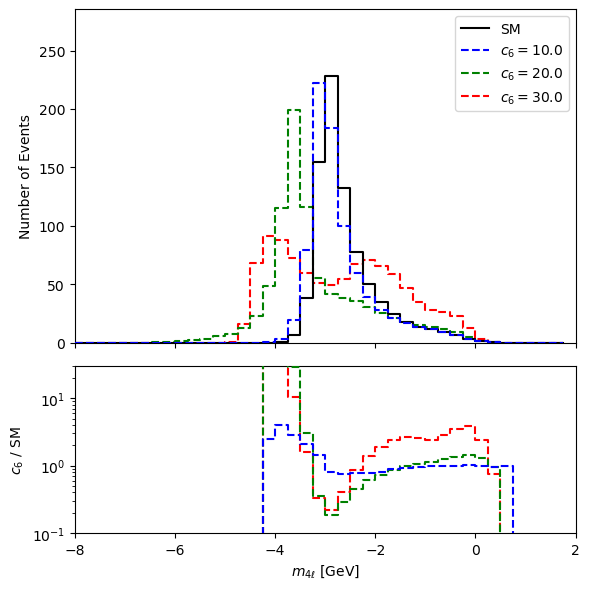

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True, height_ratios=(2,1))

ds_bins = np.arange(-8,2.25,0.25)
ds_sm_centers = 0.5 * (ds_bins[1:] + ds_bins[:-1])

h_ds_sm, _ = np.histogram(ds_sm, bins=ds_bins, weights=nu_sm)
ax1.step(ds_bins[:-1], h_ds_sm, where='post', color='black', label='SM', zorder=10)

colors= 'bgrcmy'
for i, c6_val in enumerate(c6_vals):
  if np.isclose(c6_val, 0.0):
    continue
  h_ds_c6, _ = np.histogram(ds_c6[:, i], bins=ds_bins, weights=nu_c6[:, i])
  ax1.step(ds_bins[:-1], h_ds_c6, '--', color=colors[i], where='post', label=f'$c_6 = {c6_val}$', zorder=10-i)
  ratio = np.divide(h_ds_c6, h_ds_sm, out=np.zeros_like(h_ds_sm), where=h_ds_sm!=0)
  ax2.step(ds_bins[:-1], ratio, '--', color=colors[i],  where='post', label=f'$c_6 = {c6_val}$', zorder=10-i)


ax1.set_xlim(-8,2)
ax1.set_ylabel('Number of Events')
ax1.set_ylim(0, 1.25*np.max(h_ds_sm))
ax1.legend()

ax2.set_xlabel('$m_{4\\ell}$ [GeV]')
ax2.set_ylabel('$c_6$ / SM')
ax2.set_ylim(0.1,30.0)
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

Okay, the total yield has changed, but the overall trend in $c_6$ corrections seem to be similar between $gg-$initiated SBI sample and $gg+q\bar{q}$-inclusive sample. This is quite in contrast to the paper results...

Unless, the paper only accounted for $c_6$ corrections in SBI, not $q\bar{q}$-initiated channels, let's try this.

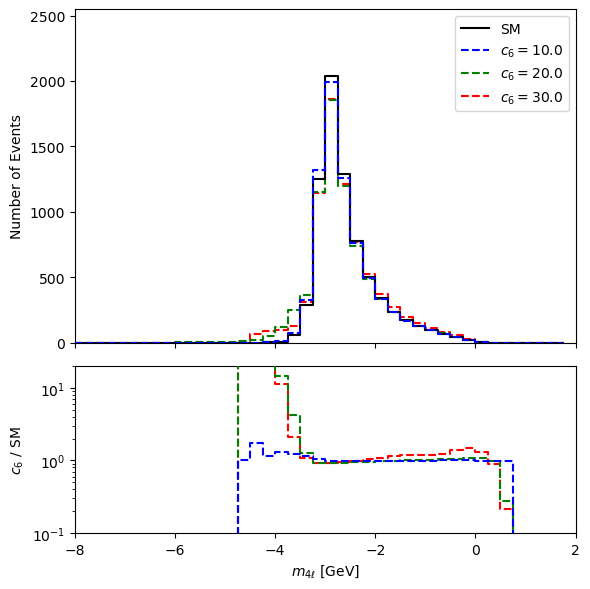

In [11]:
# concatenate on top of gg(->h*)->zz
ds_sm = np.concatenate((sbi_ds_sm, bkg_ds_sm))
nu_sm = np.concatenate((sbi_nu_sm, bkg_nu_sm))
ds_c6 = np.concatenate((sbi_ds_c6, np.repeat(bkg_ds_sm[:, np.newaxis], len(c6_vals), axis=1)), axis=0)
nu_c6 = np.concatenate((sbi_nu_c6, np.repeat(bkg_nu_c6, len(c6_vals), axis=1)), axis=0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True, height_ratios=(2,1))

ds_bins = np.arange(-8,2.25,0.25)
ds_sm_centers = 0.5 * (ds_bins[1:] + ds_bins[:-1])

h_ds_sm, _ = np.histogram(ds_sm, bins=ds_bins, weights=nu_sm)
ax1.step(ds_bins[:-1], h_ds_sm, where='post', color='black', label='SM', zorder=10)

colors= 'bgrcmy'
for i, c6_val in enumerate(c6_vals):
  if np.isclose(c6_val, 0.0):
    continue
  h_ds_c6, _ = np.histogram(ds_c6[:, i], bins=ds_bins, weights=nu_c6[:, i])
  ax1.step(ds_bins[:-1], h_ds_c6, '--', color=colors[i], where='post', label=f'$c_6 = {c6_val}$', zorder=10-i)
  ratio = np.divide(h_ds_c6, h_ds_sm, out=np.zeros_like(h_ds_sm), where=h_ds_sm!=0)
  ax2.step(ds_bins[:-1], ratio, '--', color=colors[i],  where='post', label=f'$c_6 = {c6_val}$', zorder=10-i)


ax1.set_xlim(-8,2)
ax1.set_ylabel('Number of Events')
ax1.set_ylim(0, 1.25*np.max(h_ds_sm))
ax1.legend()

ax2.set_xlabel('$m_{4\\ell}$ [GeV]')
ax2.set_ylabel('$c_6$ / SM')
ax2.set_ylim(0.1,20.0)
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

So this almost on-the-dot reproduces the paper results. 

Also, this actually makes no sense: to compute a $c_6$-parametrized observable for an SBI sample (reminder: the B standards for $gg\to ZZ$ continuum background), but not the $q\bar{q}\to ZZ$ background?

Let's stick with the correct definition.

## $D_S$-based constraint on $c_6$

Now the task is to minimize
$$t_{c_6} = \prod_{i} \mathcal{P}( n_i(c_6) | \nu_i(c_6))$$

In [12]:
# define a finer grid for the scan
c6_pts = np.linspace(-20.0, 20.0, 201)

sbi_ds_sm = np.log10(sbi_gghzz.msq() / (sbi_ggzz.msq() + 0.1*0.5*sbi_uubzz.msq()))
sbi_nu_sm = sbi_ggzz.nu(per_event=True)
sbi_msq_gghzz_c6 = sbi_gghzz.msq(c6_pts)
sbi_msq_ggzz_c6 = sbi_ggzz.msq(c6_pts)
sbi_ds_c6 = np.log10(sbi_msq_gghzz_c6 / (sbi_msq_ggzz_c6 + 0.1*0.5*(sbi_uubzz.msq())[:, np.newaxis]))
sbi_nu_c6 = sbi_ggzz.nu(c6_pts,per_event=True)

# ignore qqbar for now

# bkg_ds_sm = np.log10(bkg_gghzz.msq() / (bkg_ggzz.msq() + 0.1*0.5*bkg_uubzz.msq()))
# bkg_nu_sm = bkg_qqbzz.nu(per_event=True)
# bkg_msq_gghzz_c6 = bkg_gghzz.msq(c6_pts)
# bkg_msq_ggzz_c6 = bkg_ggzz.msq(c6_pts)
# bkg_ds_c6 = np.log10(bkg_msq_gghzz_c6 / (bkg_msq_ggzz_c6 + 0.1*0.5*(bkg_uubzz.msq())[:, np.newaxis]))
# bkg_nu_c6 = bkg_nu_sm[:,np.newaxis] # qqb receives no c6 modiciations

# ds_sm = np.concatenate((sbi_ds_sm, bkg_ds_sm))
# nu_sm = np.concatenate((sbi_nu_sm, bkg_nu_sm))
# ds_c6 = np.concatenate((sbi_ds_c6, np.repeat(bkg_ds_sm[:,np.newaxis], len(c6_pts), axis=1)), axis=0)
# nu_c6 = np.concatenate((sbi_nu_c6, np.repeat(bkg_nu_sm[:,np.newaxis], len(c6_pts), axis=1)), axis=0)

ds_sm = sbi_ds_sm
nu_sm = sbi_nu_sm
ds_c6 = sbi_ds_c6
nu_c6 = sbi_nu_c6

/tmp/ipykernel_124241/1303294954.py:8: RuntimeWarning: invalid value encountered in log10
  sbi_ds_c6 = np.log10(sbi_msq_gghzz_c6 / (sbi_msq_ggzz_c6 + 0.1*0.5*(sbi_uubzz.msq())[:, np.newaxis]))


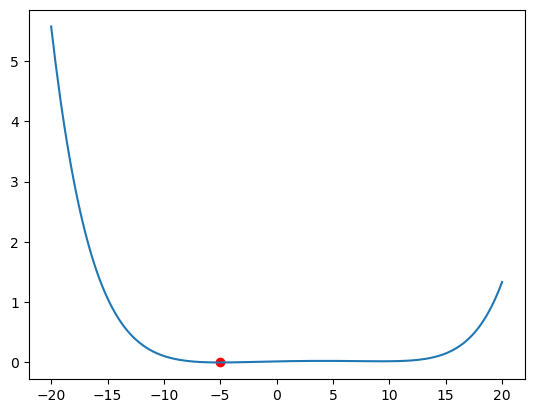

5.56976276953543


In [27]:
ds_bins = np.arange(-4.4,0.6,0.2)

# compute the nll
nll = np.zeros_like(c6_pts)
for i, c6_val in enumerate(c6_pts):
  h_ds_obs, _ = np.histogram(ds_c6[:, i], bins=ds_bins, weights=nu_sm)
  h_ds_exp, _ = np.histogram(ds_c6[:, i], bins=ds_bins, weights=nu_c6[:,i])
  nll[i] = stat.nll(h_ds_obs, h_ds_exp)
nll = nll - np.min(nll)

# find minimum
imin = np.argmin(nll)
nll_min = nll[imin]
c6_at_nll_min = c6_pts[imin]

# plot the scan + minimum
plt.plot(c6_pts, nll)
plt.scatter(c6_at_nll_min, nll_min, marker='o', color='red')
plt.show()

print(np.max(nll))

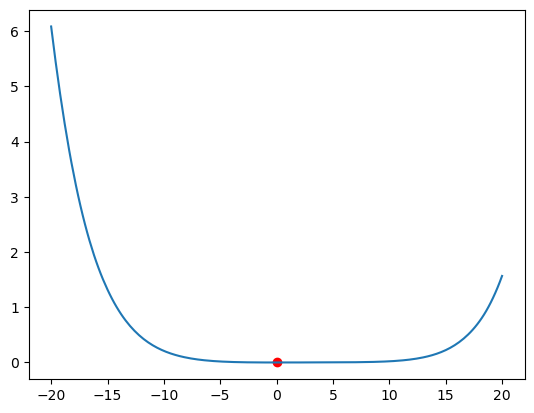

6.083978264368682


In [33]:
importlib.reload(stat)

# compute the nll
tc6 = np.zeros_like(c6_pts)
for i, c6_val in enumerate(c6_pts):
  h_ds_obs, _ = np.histogram(ds_c6[:,i], bins=ds_bins, weights=nu_sm)
  h_ds_exp, _ = np.histogram(ds_c6[:,i], bins=ds_bins, weights=nu_c6[:,i])
  tc6[i] = stat.nll(h_ds_obs, h_ds_exp) - stat.nll(h_ds_obs, h_ds_obs)

# find minimum
imin = np.argmin(nll)
tc6_min = nll[imin]
c6_at_nll_min = c6_pts[imin]

# plot the scan + minimum
plt.plot(c6_pts, nll)
plt.scatter(c6_at_nll_min, nll_min, marker='o', color='red')
plt.show()

print(np.max(nll))

In [13]:
c6_pts = np.round(c6_pts, decimals = 1)
df = pd.DataFrame({'c6' : c6_pts, 'nll' : nll})
df.to_csv('c6_nll_ds.csv', index=False)